In [ ]:
from PIL import Image
import numpy as np
 
def generate():
    for index, row in df.iterrows():
        image = read_and_resize(row['filepath'])
        yield image, row['gender']
 
def read_and_resize(filepath, input_shape=(299, 299)):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize(input_shape)
    im_array = np.array(im, dtype="uint8")#[..., ::-1]
    return np.array(im_array / (np.max(im_array)+ 0.001), dtype="float32")

In [ ]:
import matplotlib.pyplot as plt

i = 1
for image, gender in generate():
    plt.imshow(image)
    print(gender)
    i -= 1
    if i == 0:
        break

In [31]:

# Load partially trained model
model = tf.keras.models.load_model("/content/models/03")

In [33]:
model.save('/content/drive/My Drive/CZ4042/models/celeba03')

INFO:tensorflow:Assets written to: /content/drive/My Drive/CZ4042/models/celeba03/assets


In [ ]:
test_loss, test_acc = model.evaluate(test_data_gen, verbose=2)

print(test_acc)

# Setup

In [ ]:
!nvidia-smi

Thu Nov 19 07:16:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf

# This is required when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_HEIGHT = 299
IMG_WIDTH = 299
BATCH_SIZE = 32
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

histories = {}

In [ ]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
import os

if not os.path.exists('/content/models'):
    os.mkdir('/content/models')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/models/{epoch:02d}',
                                                monitor='val_acc',
                                                mode="max")
log = tf.keras.callbacks.CSVLogger('/content/models/log.csv')
time_callback = TimeHistory()

In [ ]:
#get all required files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()

def folder_list(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3').files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [f['id'] for f in res['files']]

def folder_download(folder_id):
  for fid in folder_list(folder_id):
    !gdown -q --id $fid

link='https://drive.google.com/drive/folders/1mj-LAHcnvUiWcsM5y0HZKCVCW6cpgHU0'

folder_id="1mj-LAHcnvUiWcsM5y0HZKCVCW6cpgHU0"

folder_download(folder_id)



---

### Load CelebA Dataset

In [ ]:
!unzip "/content/img_align_celeba.zip"

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('list_attr_celeba.txt', header=0, delim_whitespace=True)
df['Male'] = df['Male'].astype(str)
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen_ca = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/img_align_celeba/',
                                                     x_col='image_id',
                                                     y_col='Male',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen_ca = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/img_align_celeba/',
                                                    x_col='image_id',
                                                    y_col='Male',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 162079 validated image filenames belonging to 2 classes.
Found 40520 validated image filenames belonging to 2 classes.




---

### Load Adience Dataset

In [ ]:
!unzip "/content/aligned.zip"

In [ ]:
df = pd.DataFrame()
for i in range(0,5):
    df = pd.concat([df, pd.read_csv(f'fold_{i}_data.txt', sep='\t')])

In [ ]:
from sklearn.model_selection import train_test_split

df = df[df['gender'].notna()]
df = df[df['age'] != 'None']
df.loc[df['age'] == '(27, 32)', 'age'] = '(25, 32)'
df.loc[df['age'] == '(38, 42)', 'age'] = '(38, 43)'
df.loc[df['age'] == '29', 'age'] = '(25, 32)'
df.loc[df['age'] == '2', 'age'] = '(0, 2)'
df.loc[df['age'] == '42', 'age'] = '(38, 43)'
df['age'].value_counts()
df = df[df.age.isin(['(0, 2)',
                     '(4, 6)',
                     '(8, 12)',
                     '(15, 20)',
                     '(25, 32)',
                     '(38, 43)',
                     '(48, 53)',
                     '(60, 100)'])]
df = df[df['gender'] != 'u']
df['filepath'] = df.apply(lambda row: row['user_id'] +
                          '/landmark_aligned_face.' + str(row['face_id']) + '.' +
                          row['original_image'],
         axis = 1
)
df = df.loc[:, ['filepath', 'age', 'gender']]

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/aligned/',
                                                    x_col='filepath',
                                                    y_col='gender',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.
Found 3274 validated image filenames belonging to 2 classes.




---

## Benchmark

---



### ImageNet weights, no data augmentation

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

test_data_gen = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/aligned/',
                                                    x_col='filepath',
                                                    y_col='gender',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.
Found 3274 validated image filenames belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

87916544/87910968 [==============================] - 3s 0us/step


In [ ]:
history = model.fit(train_data_gen,
                    epochs=20,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)
histories['benchmark'] = (history, time_callback.times)

Epoch 1/20
410/410 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.8511WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/models/01/assets
410/410 [==============================] - 267s 652ms/step - loss: 0.3247 - accuracy: 0.8511 - val_loss: 0.2001 - val_accuracy: 0.9206
Epoch 2/20
410/410 [==============================] - 256s 624ms/step - loss: 0.1222 - accuracy: 0.9538 - val_loss: 0.2331 - val_accuracy: 0.9065
Epoch 3/20
410/410 [==============================] - 258s 628ms/step - loss: 0.0438 - accu

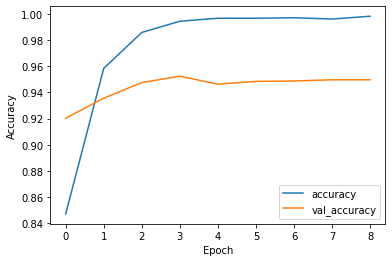

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

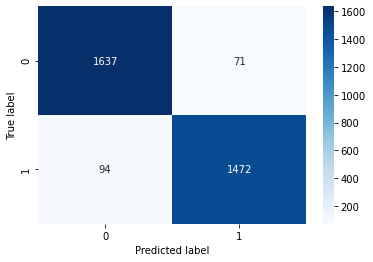

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()

predict = np.argmax(predict, axis=1)

cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ImageNet weights, Data augmentation

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data_gen,
                    epochs=25,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/25
410/410 [==============================] - 522s 1s/step - loss: 0.3523 - accuracy: 0.8384 - val_loss: 0.2434 - val_accuracy: 0.8998
Epoch 2/25
410/410 [==============================] - 517s 1s/step - loss: 0.1779 - accuracy: 0.9280 - val_loss: 0.1511 - val_accuracy: 0.9420
Epoch 3/25
410/410 [==============================] - 534s 1s/step - loss: 0.1323 - accuracy: 0.9500 - val_loss: 0.1279 - val_accuracy: 0.9557
Epoch 4/25
410/410 [==============================] - 531s 1s/step - loss: 0.0962 - accuracy: 0.9650 - val_loss: 0.1286 - val_accuracy: 0.9527
Epoch 5/25
410/410 [==============================] - 521s 1s/step - loss: 0.0793 - accuracy: 0.9705 - val_loss: 0.1273 - val_accuracy: 0.9530
Epoch 6/25
410/410 [==============================] - 515s 1s/step - loss: 0.0604 - accuracy: 0.9802 - val_loss: 0.1354 - val_accuracy: 0.9578
Epoch 7/25
410/410 [==============================] - 513s 1s/step - loss: 0.0545 - accuracy: 0.9812 - val_loss: 0.1106 - val_accuracy: 0.9627

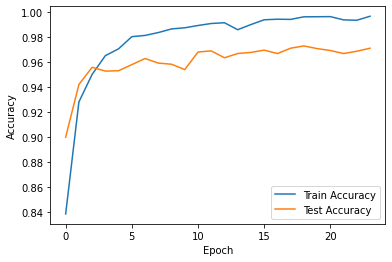

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

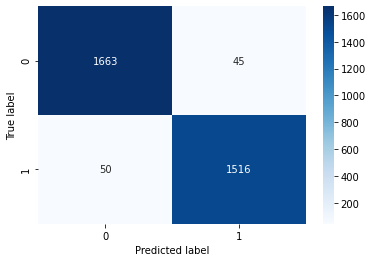

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()

predict = np.argmax(predict, axis=1)

cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

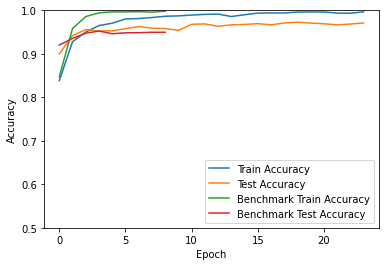

In [ ]:
# Compare with baseline
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.plot(histories['benchmark'][0].history['accuracy'], label='Benchmark Train Accuracy')
plt.plot(histories['benchmark'][0].history['val_accuracy'], label='Benchmark Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
pd.DataFrame([[sum(histories['benchmark'][1][1:]) / len(histories['benchmark'][1][1:]), sum(histories['benchmark'][1])],
              [sum(time_callback.times[1:])/len(time_callback.times[1:]),sum(time_callback.times)]],
             ['Benchmark', 'Current'],
             ['Avg per Epoch', 'Total training time'])

,Avg per Epoch,Total training time
Benchmark,274.502737,2481.344435
Current,515.069000,12374.432937


# No Pretrained Weights

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights=None,
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data_gen,
                    epochs=100,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/100
410/410 [==============================] - 537s 1s/step - loss: 0.7145 - accuracy: 0.5606 - val_loss: 0.6911 - val_accuracy: 0.6072
Epoch 2/100
410/410 [==============================] - 526s 1s/step - loss: 0.6746 - accuracy: 0.6130 - val_loss: 0.6694 - val_accuracy: 0.5947
Epoch 3/100
410/410 [==============================] - 511s 1s/step - loss: 0.6293 - accuracy: 0.6556 - val_loss: 0.6604 - val_accuracy: 0.6335
Epoch 4/100
410/410 [==============================] - 502s 1s/step - loss: 0.6062 - accuracy: 0.6768 - val_loss: 0.6031 - val_accuracy: 0.6784
Epoch 5/100
410/410 [==============================] - 534s 1s/step - loss: 0.5785 - accuracy: 0.6977 - val_loss: 0.7653 - val_accuracy: 0.5889
Epoch 6/100
410/410 [==============================] - 528s 1s/step - loss: 0.5582 - accuracy: 0.7114 - val_loss: 0.7675 - val_accuracy: 0.6255
Epoch 7/100
410/410 [==============================] - 528s 1s/step - loss: 0.5284 - accuracy: 0.7332 - val_loss: 0.4975 - val_accuracy:

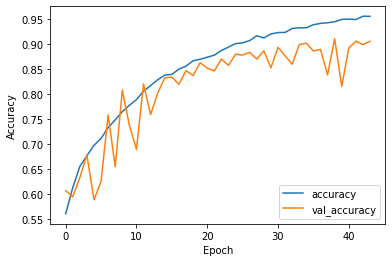

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

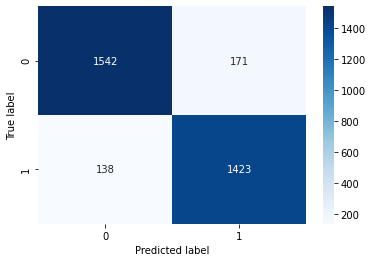

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()

predict = np.argmax(predict, axis=1)

cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
pd.DataFrame([[sum(time_callback.times[1:])/len(time_callback.times[1:]),sum(time_callback.times)]],
             ['No Pretrained Weights'],
             ['Avg per Epoch', 'Total training time'])

,Avg per Epoch,Total training time
No Pretrained Weights,498.677362,21987.943659


# Deeper Classification Network

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
history = model.fit(train_data_gen,
                    epochs=30,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/30
410/410 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.8464WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/models/01/assets
410/410 [==============================] - 253s 617ms/step - loss: 0.3332 - accuracy: 0.8464 - val_loss: 0.1880 - val_accuracy: 0.9236
Epoch 2/30
410/410 [==============================] - 247s 601ms/step - loss: 0.1256 - accuracy: 0.9527 - val_loss: 0.1623 - val_accuracy: 0.9380
Epoch 3/30
410/410 [==============================] - 245s 596ms/step - loss: 0.0452 - accu

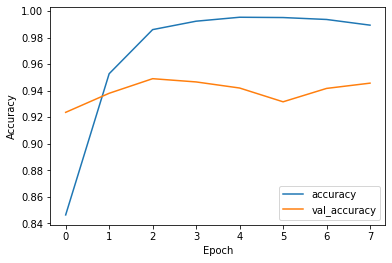

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

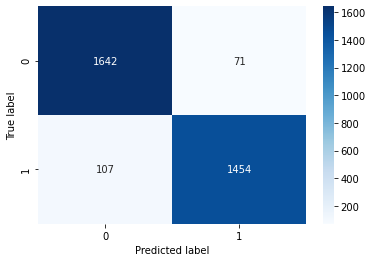

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
 
model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()
 
predict = np.argmax(predict, axis=1)
 
cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
pd.DataFrame([[sum(time_callback.times[1:])/len(time_callback.times[1:]),sum(time_callback.times)]],
             ['Deep'],
             ['Avg per Epoch', 'Total training time'])

,Avg per Epoch,Total training time
Deep,245.265501,1982.109493


# Pretraining on CelebA

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('list_attr_celeba.txt', header=0, delim_whitespace=True)
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
# All features (Except image_id)
for i in df.columns.values[1:]:
    df.loc[df[i] == -1, i] = 0
# All features except gender
features = [i for i in df.columns.values[1:] if i != 'Male']
print(len(features))

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

39


In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen_ca = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/img_align_celeba/',
                                                     x_col='image_id',
                                                     y_col=features,
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='raw',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen_ca = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/img_align_celeba/',
                                                    x_col='image_id',
                                                    y_col=features,
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='raw',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 162079 validated image filenames.
Found 40520 validated image filenames.


In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(39, activation='sigmoid'))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data_gen_ca,
                    epochs=100,
                    initial_epoch=0,
                    validation_data=test_data_gen_ca,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/100
5065/5065 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.0136WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/models/01/assets
5065/5065 [==============================] - 4594s 907ms/step - loss: 0.6984 - accuracy: 0.0136 - val_loss: 0.6805 - val_accuracy: 0.0129
Epoch 2/100
 713/5065 [===>..........................] - ETA: 1:00:31 - loss: 0.6798 - accuracy: 0.0131

KeyboardInterrupt: ignored

# Pretrain Gender only

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('list_attr_celeba.txt', header=0, delim_whitespace=True)

df.loc[df['Male'] == 1, 'Male'] = 'm'
df.loc[df['Male'] == -1, 'Male'] = 'f'

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen_ca = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/img_align_celeba/',
                                                     x_col='image_id',
                                                     y_col='Male',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen_ca = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/img_align_celeba/',
                                                    x_col='image_id',
                                                    y_col='Male',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 162079 validated image filenames belonging to 2 classes.
Found 40520 validated image filenames belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
history = model.fit(train_data_gen_ca,
                    epochs=100,
                    initial_epoch=0,
                    validation_data=test_data_gen_ca,
                    callbacks=[early_stop, checkpoint, log, time_callback],
                    verbose=1)

Epoch 1/100
5065/5065 [==============================] - 4424s 873ms/step - loss: 0.0774 - accuracy: 0.9721 - val_loss: 0.0464 - val_accuracy: 0.9846
Epoch 2/100
5065/5065 [==============================] - 4402s 869ms/step - loss: 0.0402 - accuracy: 0.9862 - val_loss: 0.0379 - val_accuracy: 0.9873
Epoch 3/100
5065/5065 [==============================] - 4561s 900ms/step - loss: 0.0323 - accuracy: 0.9890 - val_loss: 0.0386 - val_accuracy: 0.9865
Epoch 4/100
 239/5065 [>.............................] - ETA: 1:06:16 - loss: 0.0218 - accuracy: 0.9925

KeyboardInterrupt: ignored

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________